In [1]:
from keras.preprocessing.image import load_img, save_img, img_to_array

import numpy as np

import scipy
import argparse
from keras.applications import inception_v3
from keras.applications.vgg19 import VGG19
from keras import backend as K

def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Using TensorFlow backend.


## Load model

In [2]:
K.set_learning_phase(0)

# Build the VGG19 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = VGG19(include_top=False, weights='imagenet')
dream = model.input
print('Model loaded.')

Model loaded.


## Prepare the loss function

In [3]:
base_image_path = 'base_image.jpg'
result_prefix = 'results/dream'
result_file_format = '.png'

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
settings = {
    'features': {
        'block5_conv1': 0.001,
        'block5_conv2': 0.001,
    },
}

# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss = loss + coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss = loss + coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

## Processing loop

In [7]:
"""Process:

- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.

To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.
"""

# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 5  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 5  # Number of ascent steps per scale
max_loss = 10.

img = preprocess_image(base_image_path)

# Add some noise.
#
# Toggle this to change the effect.
# TODO: Doesn't produce as good of results as I would want
# noise_level = 5
# noise = np.random.randint(-noise_level, noise_level, size=img.shape)
# img = np.clip(img + noise, -128, 128)

if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape, index in enumerate(successive_shapes):
    print('Processing image shape', shape, index, len(successive_shapes))
    img = resize_img(img, shape)
    
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

save_img(result_prefix + result_file_format, deprocess_image(np.copy(img)))
print('Done.')

Processing image shape (484, 749)
..Loss value at 0 : 0.0045062792
..Loss value at 1 : 0.0069670235
..Loss value at 2 : 0.010787272
..Loss value at 3 : 0.015455766
..Loss value at 4 : 0.020712709
Processing image shape (678, 1049)
..Loss value at 0 : 0.012517128
..Loss value at 1 : 0.018848944
..Loss value at 2 : 0.025711197
..Loss value at 3 : 0.03352856
..Loss value at 4 : 0.042979747
Processing image shape (950, 1469)
..Loss value at 0 : 0.019295027
..Loss value at 1 : 0.02901125
..Loss value at 2 : 0.039771624
..Loss value at 3 : 0.051443692
..Loss value at 4 : 0.065889984
Processing image shape (1330, 2057)
..Loss value at 0 : 0.027739031
..Loss value at 1 : 0.038690314
..Loss value at 2 : 0.048824646
..Loss value at 3 : 0.059242144
..Loss value at 4 : 0.07121734
Processing image shape (1862, 2880)
..Loss value at 0 : 0.02843166
..Loss value at 1 : 0.0353701
..Loss value at 2 : 0.041339695
..Loss value at 3 : 0.04725539
..Loss value at 4 : 0.053451918
Done.


## Output

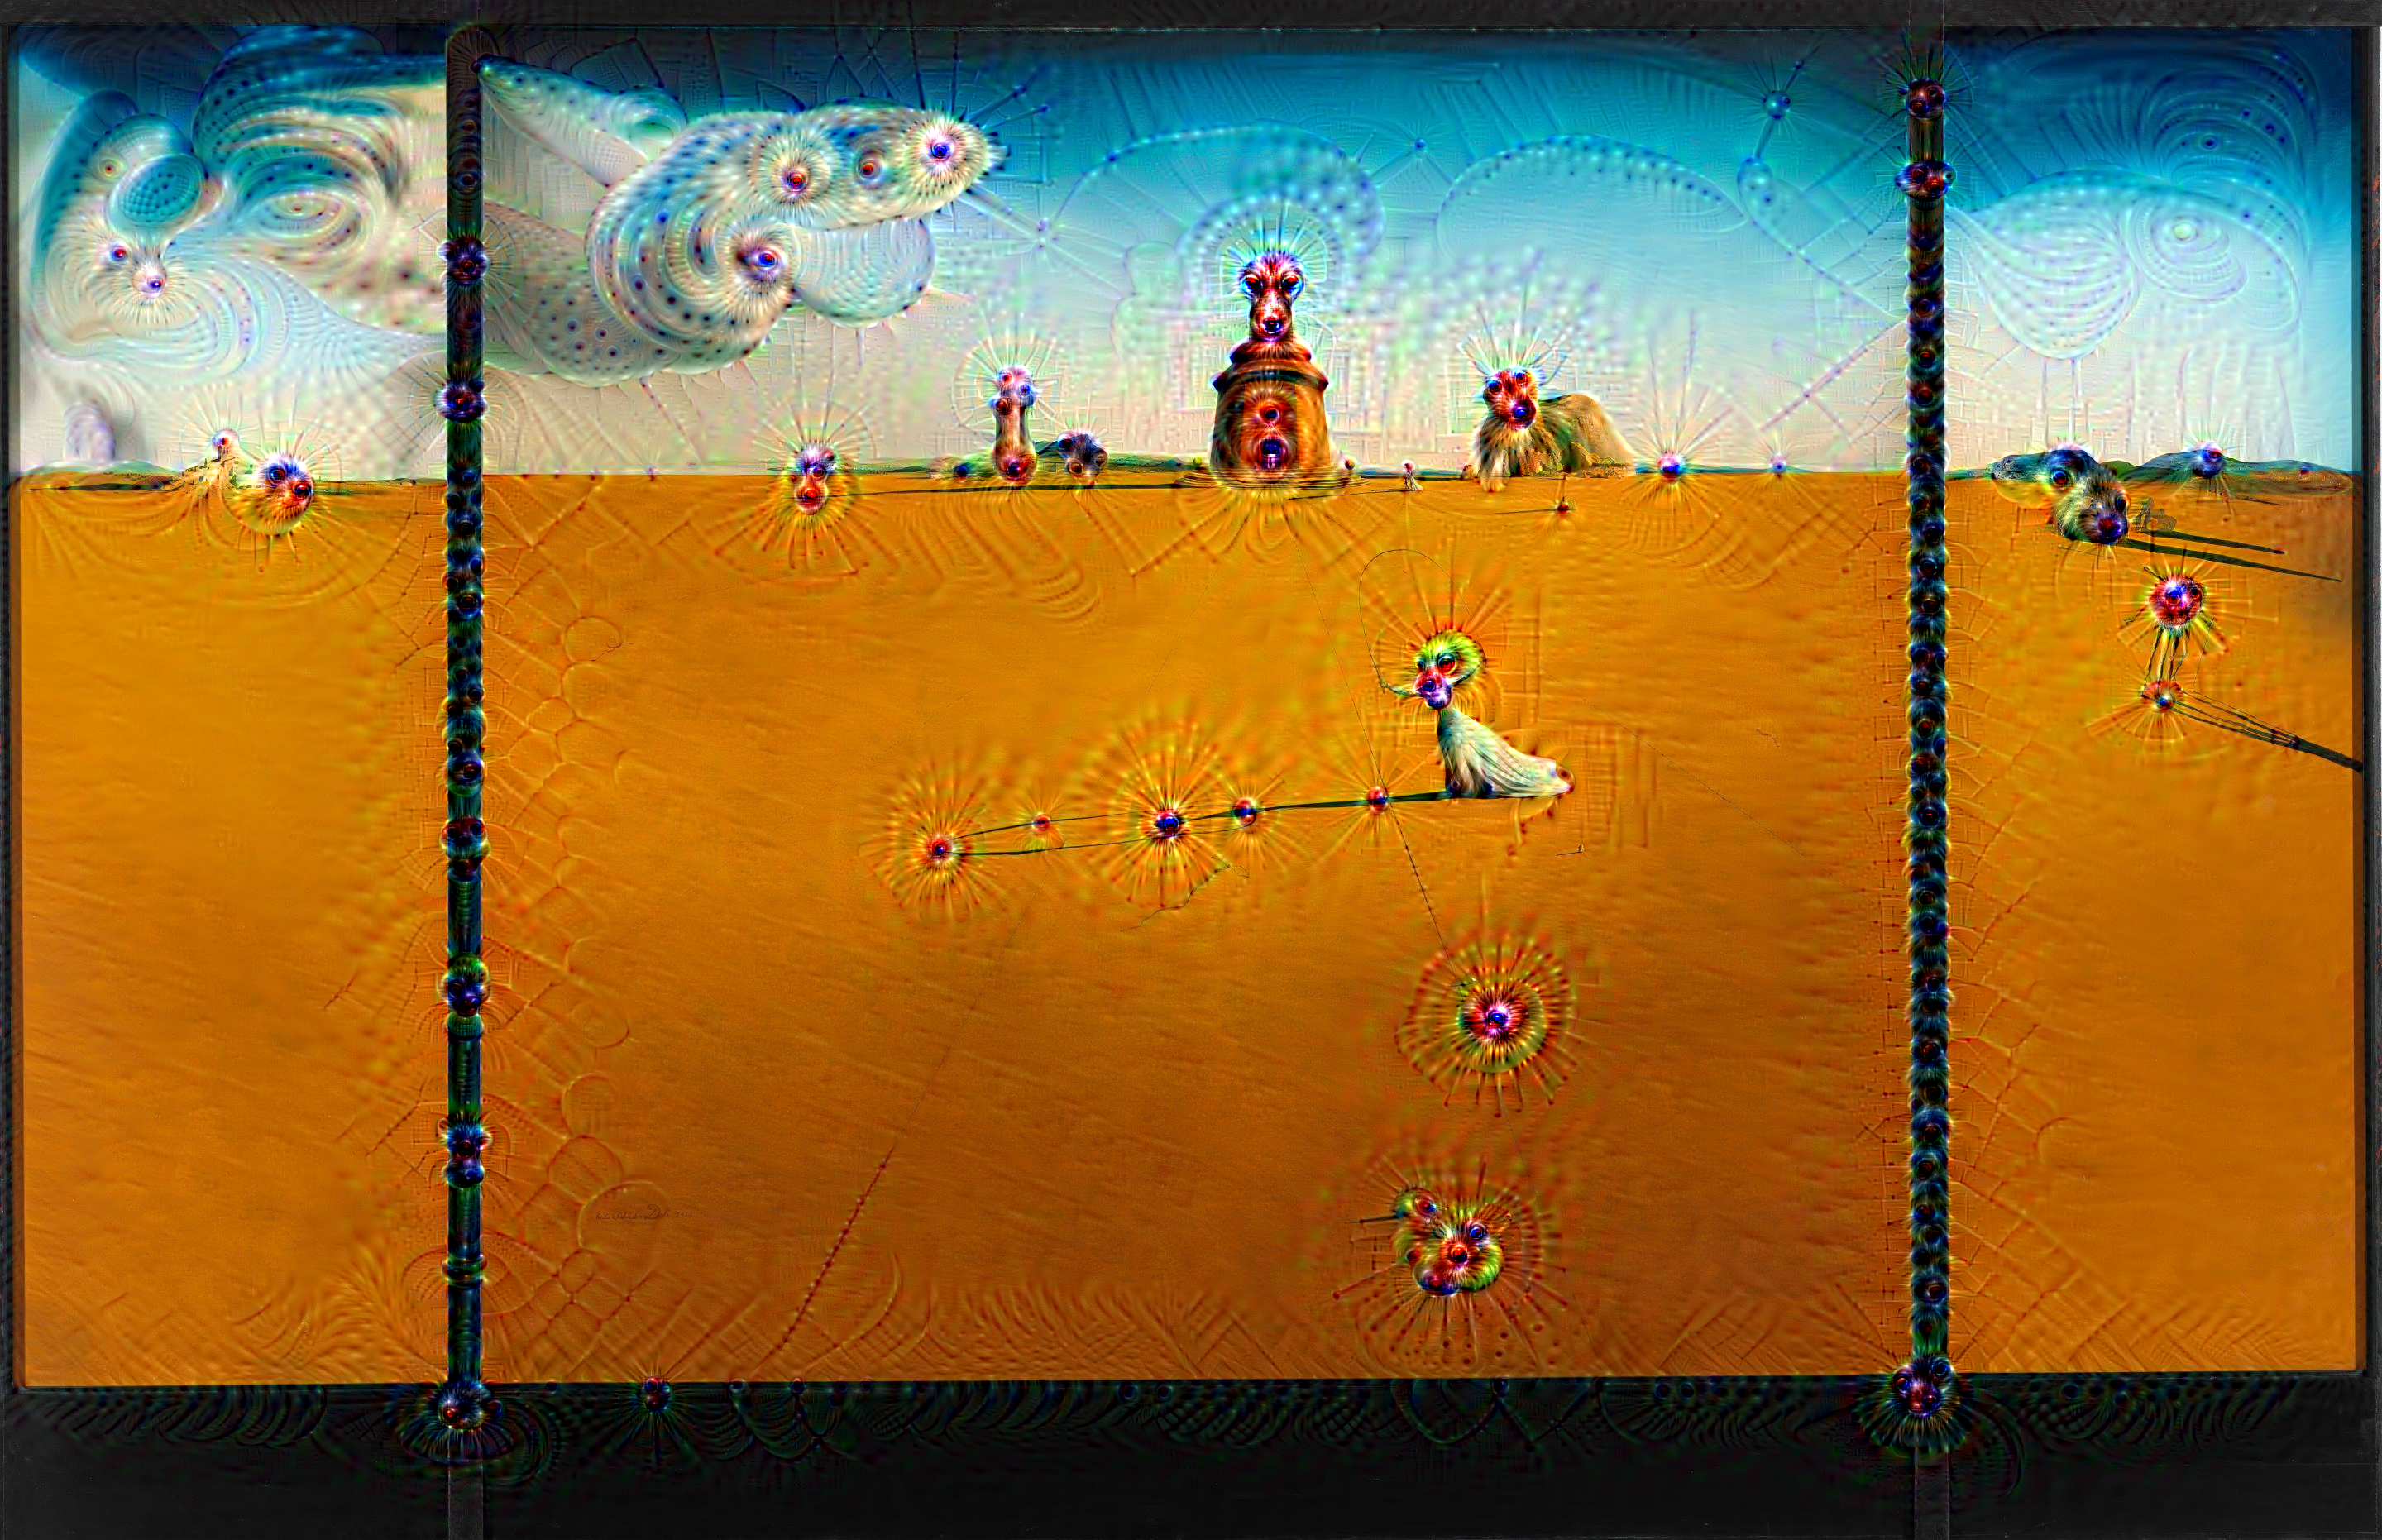

In [8]:
from IPython.display import Image, display
display(Image(filename=result_prefix + result_file_format))

## Original

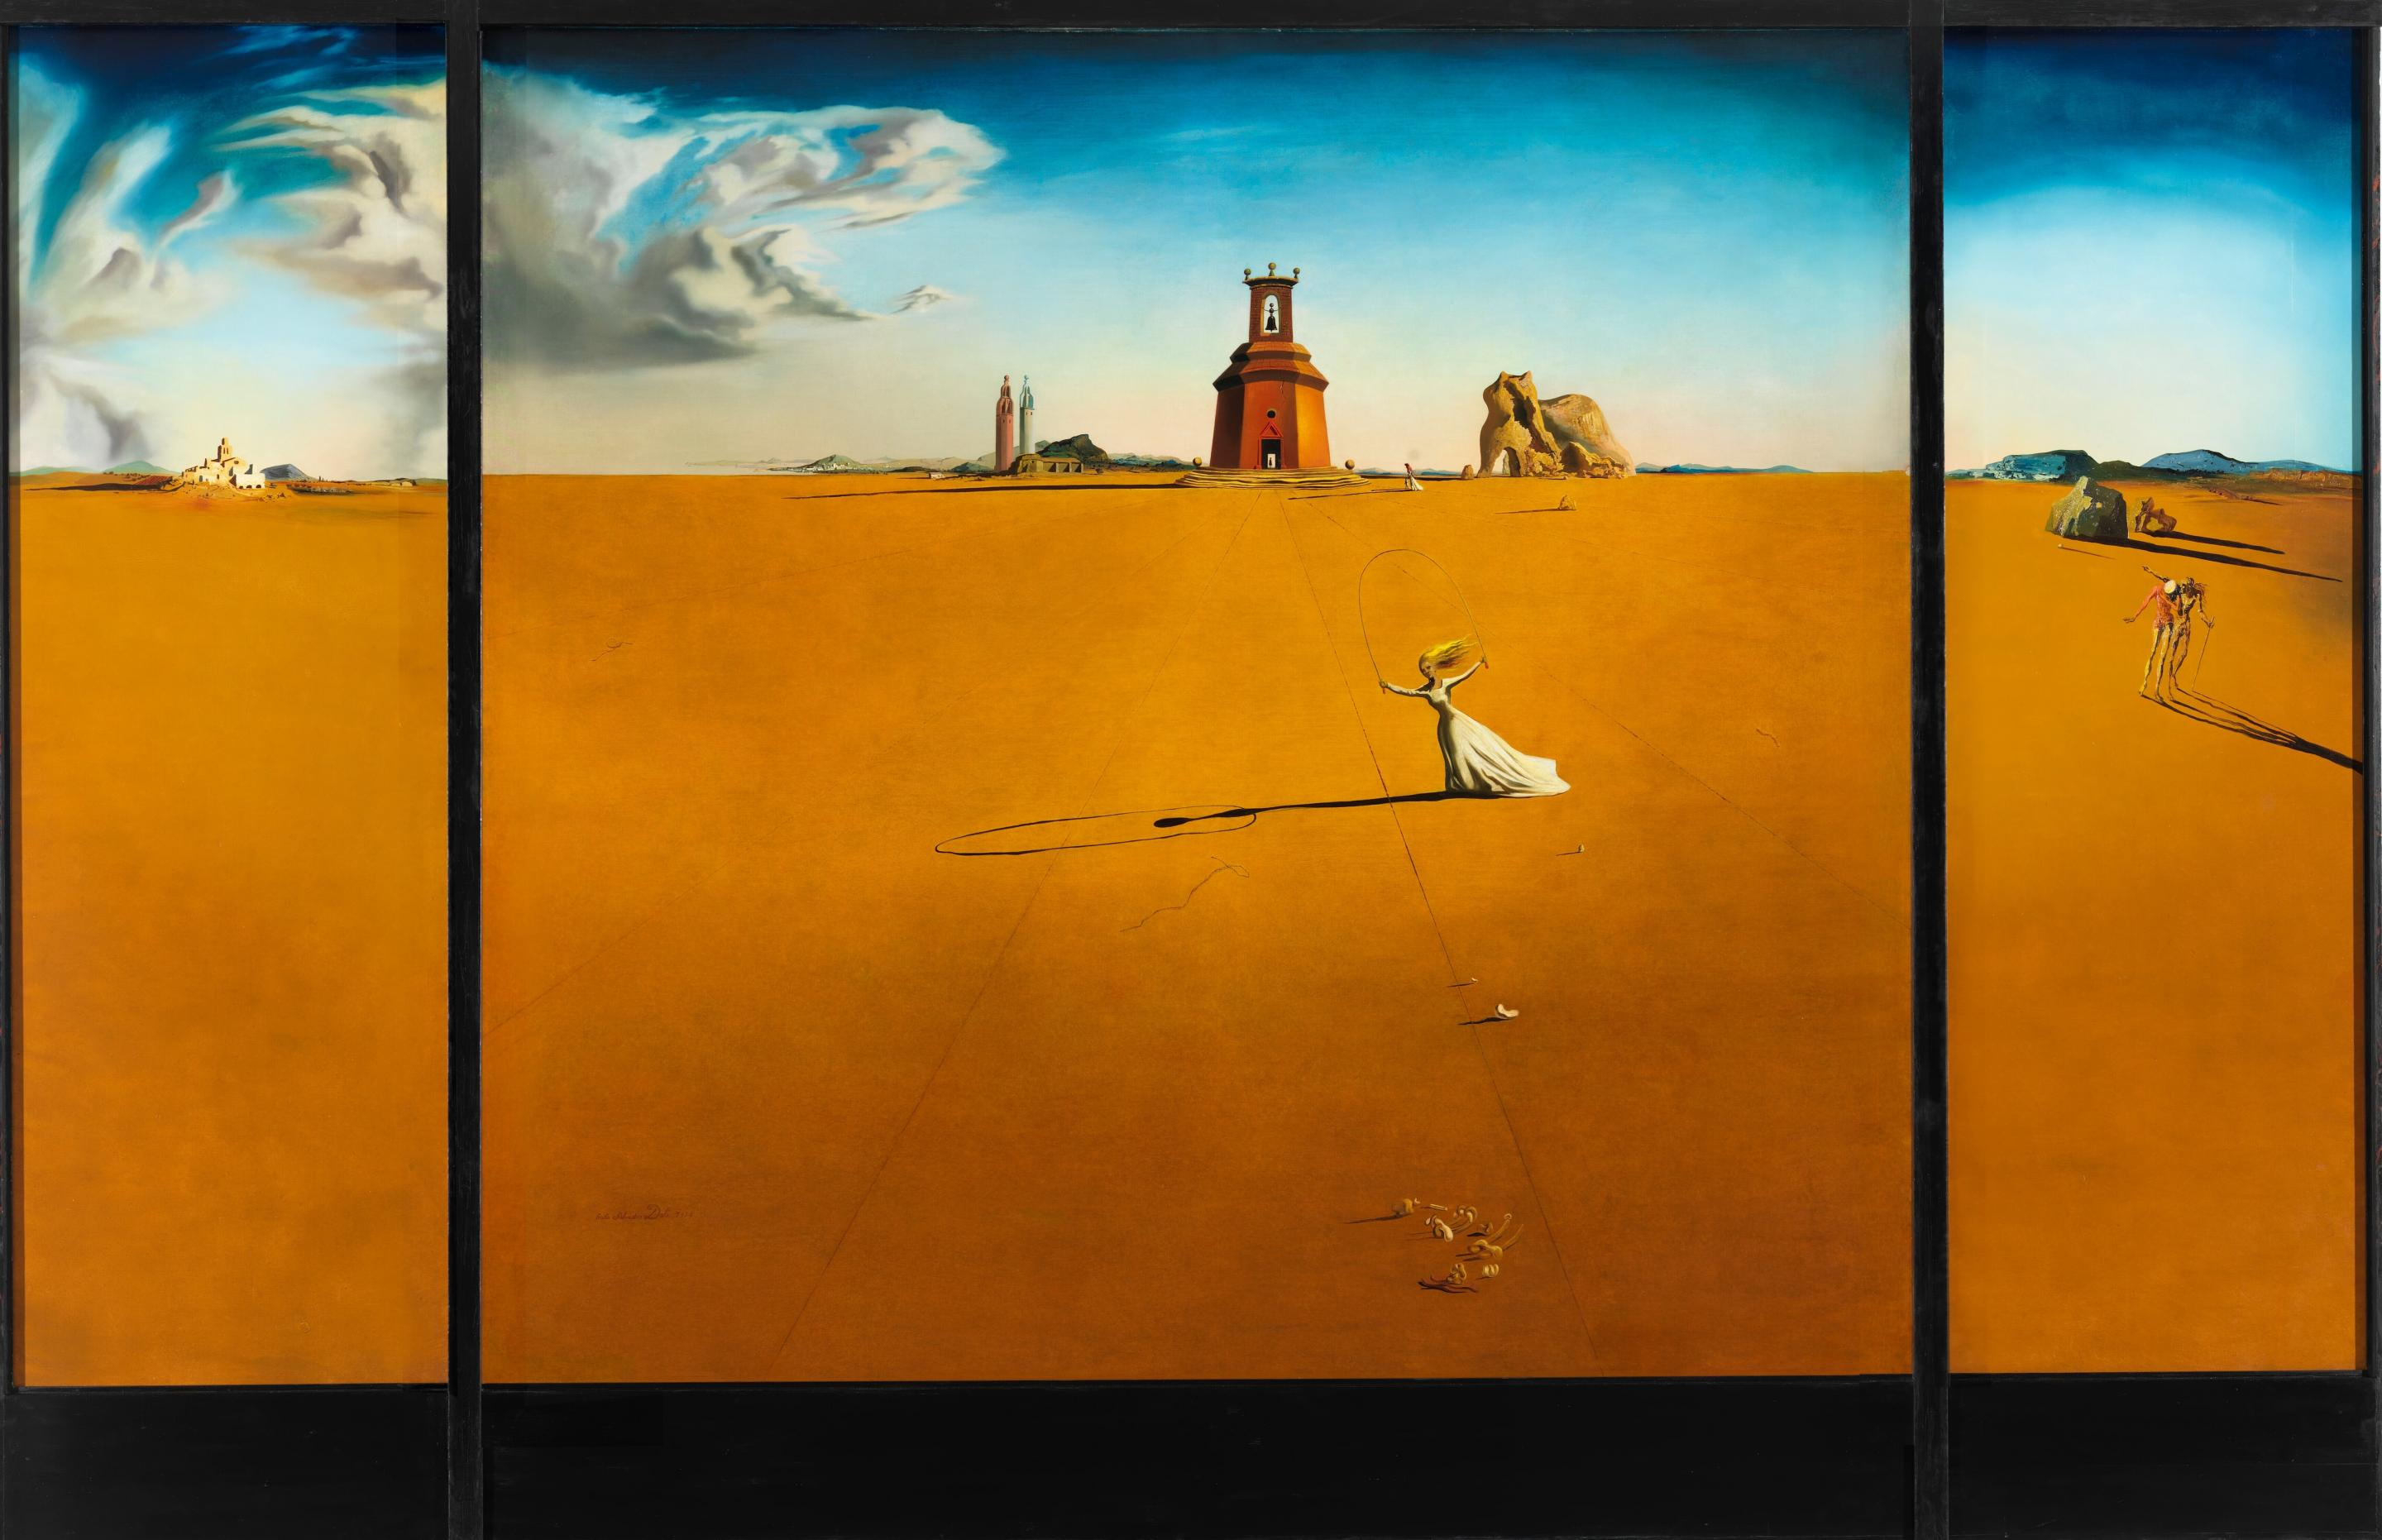

In [9]:
display(Image(filename=base_image_path))

## Notes

A CNN is made up of layers. Layers each have a number of filters (also called channels). The CNN takes an input and produces an output by passing the input through the pipeline of layers. In normal operation, the output is a vector of probabilities of classifications.

In normal operation training, we run gradient descent with fixed data, updating weights of different filters.

In deep dream training, we run gradient descent with fixed weights, updating input data to produce an image that has "high activation" of certain filters that we care about.

### Tensors

* Fundamental object in Keras / TensorFlow
* Tensors are generalized object for storing weights or data
* Nice thing is that you can "optimize over" either weights or data b/c the data structure is the same
    
### Loss

* Loss is the thing you're trying to optimize
* May better be described as the "objective function"
* Way to measure "error" in the network
* Loss will be large when prediction differs heavily from actual labels

In our code above, the loss is calculated by taking a set of filters (settings.features) (i.e. channels in possibly many layers) and averaging them in some way (above we use sum of squares divided by number of pixels).

In our code, loss is basically the degree to which certain filters that we care about are activated.

### Gradient descent

* Iteratively update parameters/data to optimize the loss function
* Can be thought of like rolling a ball (updating parameters) down a hill until finding the low point (the hill is the loss)
* The "Gradient" is basically the slope of the loss function, so we're looking for the parameters (i.e. weights or data) where the gradient is "0".
    * Note that we're dealing with multi-dimensional parameters, so the gradient would actually be a vector. That's why it's represented as a tensor in Keras. (The loss is also represented as a tensor for convenience, even though it will be an actual numerical value)

In our code, the weights are fixed. The weights are completely internal to the model + layers (there's probably something like layer.weights in Keras). So the parameters we're changing as we do the gradient descent are the actual image data.

We also run the gradient descent over scaled versions of the original image. This is done as a way to introduce some noise, which would make the filter activations more pronounced. Why? Because some layers recognize certain types of structures that are only activated with variations created by the noise and/or less granularity).